In [ ]:
import matplotlib.pyplot as plt
from torchtrainer.util.post_processing import logits_to_preds
import torch
from topology_metrics import ClDice
from confusion_metrics import ConfusionMatrixMetrics
from distance_metrics import DistanceMetrics
from PIL import Image
from torchvision.transforms import transforms
from pathlib import Path
import networkx as nx
import torch.nn.functional as F

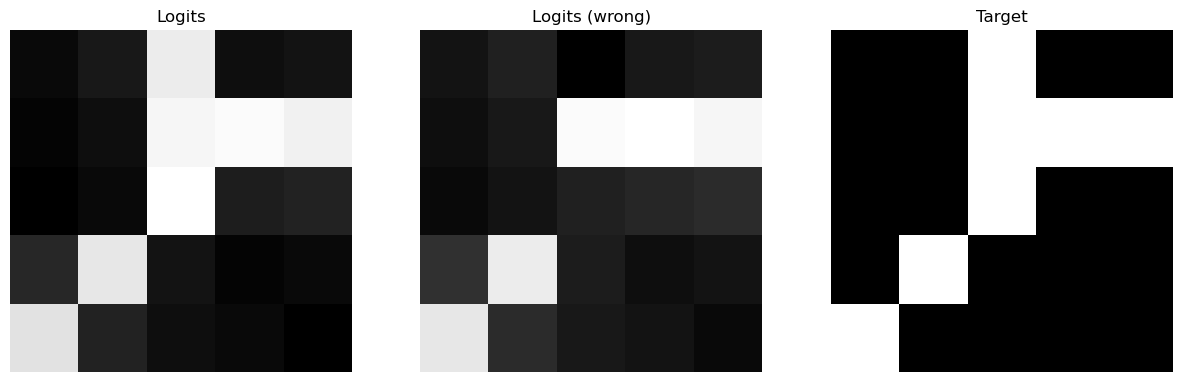

In [2]:
img = torch.tensor([
    [0, 0, 1, 0, 0],
    [0, 0, 1, 1, 1],
    [0, 0, 1, 0, 0],
    [0, 1, 0, 0, 0],
    [1, 0, 0, 0, 0]
], dtype=torch.float32)

logits = torch.tensor([
    [-2.1, -1.8,  2.5, -2.0, -1.9],
    [-2.2, -2.0,  2.7,  2.8,  2.6],
    [-2.3, -2.1,  2.9, -1.7, -1.6],
    [-1.5,  2.4, -1.9, -2.2, -2.1],
    [ 2.3, -1.6, -2.0, -2.1, -2.3]
], dtype=torch.float32)

logits_b = torch.tensor([
    [-2.1, -1.8,  -2.5, -2.0, -1.9],
    [-2.2, -2.0,  2.7,  2.8,  2.6],
    [-2.3, -2.1,  -1.8, -1.7, -1.6],
    [-1.5,  2.4, -1.9, -2.2, -2.1],
    [ 2.3, -1.6, -2.0, -2.1, -2.3]
], dtype=torch.float32)

img = F.interpolate(img.unsqueeze(0).unsqueeze(0), size=(25, 25), mode='nearest').squeeze()
logits = F.interpolate(logits.unsqueeze(0).unsqueeze(0), size=(25, 25), mode='nearest').squeeze()
logits_b = F.interpolate(logits_b.unsqueeze(0).unsqueeze(0), size=(25, 25), mode='nearest').squeeze()


logits_reshaped = logits.unsqueeze(0).unsqueeze(0)
logits_b_reshaped = logits_b.unsqueeze(0).unsqueeze(0)
img_reshaped = img.unsqueeze(0).unsqueeze(0)

preds = logits_to_preds(logits_reshaped, task="binary")

preds_np = preds.numpy().reshape(25,25)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))

axes[0].imshow(logits, cmap="gray")
axes[0].set_title("Logits")
axes[0].axis("off")

axes[1].imshow(logits_b, cmap="gray")
axes[1].set_title("Logits (wrong)")
axes[1].axis("off")

axes[2].imshow(img, cmap="gray")
axes[2].set_title("Target")
axes[2].axis("off")

plt.show()


In [3]:
save_path = Path(Path.cwd(), "save")

to_pil = transforms.ToPILImage()

image = to_pil(img)
image.save(Path(save_path, "image.tif"))

image = to_pil(logits)
image.save(Path(save_path, "logits.tif"))

image = to_pil(logits_b)
image.save(Path(save_path, "logits_b.tif"))

In [4]:
from convert_to_graph import convert_to_graph

graph_image, graph_scores = convert_to_graph(save_path, Path(save_path, "output"))

pos_label_image = {node: (data['center'][1], data['center'][0]) for node, data in graph_image.nodes(data=True)}
pos_label_scores = {node: (data['center'][1], data['center'][0]) for node, data in graph_scores.nodes(data=True)}


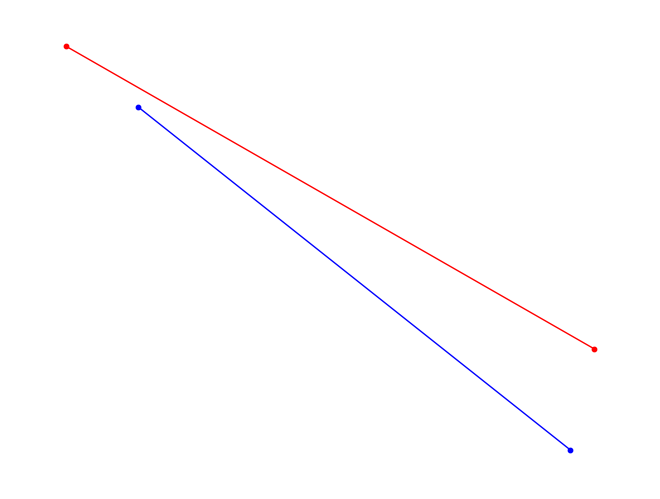

In [5]:
nx.draw(graph_scores, pos_label_scores, with_labels=False, node_color='blue', node_size=10, edge_color='blue')
nx.draw(graph_image, pos_label_image, with_labels=False, node_color='red', node_size=10, edge_color='red')
plt.show()

In [6]:
from run_metrics import run_all_metrics

distances = run_all_metrics(graph_scores, graph_image)
print(distances)

{'jaccard_distance': 0.0, 'portrait_divergence': 0, 'ipsen_mikhailov': 0.0, 'netlsd': 0.0, 'laplacian_spectral_method': 0.0, 'degree_divergence': nan, 'onion_divergence': 0.0}


/home/ivancalvo/miniconda3/envs/visao/lib/python3.12/site-packages/scipy/stats/_entropy.py:154: RuntimeWarning: invalid value encountered in divide
  qk = 1.0*qk / xp.sum(qk, **sum_kwargs)  # type: ignore[operator, call-overload]


In [9]:
distances = run_all_metrics(logits_b, img)
print(distances)

{'clDice': tensor(0.8571, dtype=torch.float64), 'confusionMatrixMetrics': (tensor(0.9200), tensor(0.7143), tensor(1.), tensor(0.7143), tensor(0.8333)), 'distanceMetrics': {'Distance gt to pred': tensor(0.8037, dtype=torch.float64), 'Distance pred to gt': tensor(0.1569, dtype=torch.float64), 'Hausdorff distance': tensor(5., dtype=torch.float64), 'Overlap fraction gt': tensor(0.7259, dtype=torch.float64), 'Overlap fraction pred': tensor(0.8954, dtype=torch.float64), 'Surface Dice': tensor(0.8014, dtype=torch.float64)}}


In [ ]:
from run_metrics import run_metrics, run_distance_metrics

print(run_metrics(logits, img))
print(run_metrics(logits_b, img))

print(run_distance_metrics(logits, img))
print(run_distance_metrics(logits_b, img))

(tensor(1., dtype=torch.float64), (tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.)))
(tensor(0.8889, dtype=torch.float64), (tensor(0.9200), tensor(0.7143), tensor(1.), tensor(0.7143), tensor(0.8333)))
{'Distance gt to pred': tensor(0., dtype=torch.float64), 'Distance pred to gt': tensor(0., dtype=torch.float64), 'Hausdorff distance': tensor(0., dtype=torch.float64), 'Overlap fraction gt': tensor(1., dtype=torch.float64), 'Overlap fraction pred': tensor(1., dtype=torch.float64), 'Surface Dice': tensor(1., dtype=torch.float64)}
{'Distance gt to pred': tensor(0.1385, dtype=torch.float64), 'Distance pred to gt': tensor(0., dtype=torch.float64), 'Hausdorff distance': tensor(1., dtype=torch.float64), 'Overlap fraction gt': tensor(0.8615, dtype=torch.float64), 'Overlap fraction pred': tensor(1., dtype=torch.float64), 'Surface Dice': tensor(0.9237, dtype=torch.float64)}


In [ ]:
clDiceClass = ClDice()

print(clDiceClass(logits_reshaped, img_reshaped))
print(clDiceClass(logits_b_reshaped, img_reshaped))

tensor(1., dtype=torch.float64)
tensor(0.8889, dtype=torch.float64)


In [ ]:
confusionMatrix = ConfusionMatrixMetrics()

print(confusionMatrix(logits_reshaped, img_reshaped))
print(confusionMatrix(logits_b_reshaped, img_reshaped))

(tensor(1.), tensor(1.), tensor(1.), tensor(1.), tensor(1.))
(tensor(0.9200), tensor(0.7143), tensor(1.), tensor(0.7143), tensor(0.8333))


In [ ]:
# In this case the image must have only three dimensions
img_reshaped = img.unsqueeze(0)

distanceMetrics = DistanceMetrics()

print(distanceMetrics(logits_reshaped, img_reshaped))
print(distanceMetrics(logits_b_reshaped, img_reshaped))

{'Distance gt to pred': tensor(0., dtype=torch.float64), 'Distance pred to gt': tensor(0., dtype=torch.float64), 'Hausdorff distance': tensor(0., dtype=torch.float64), 'Overlap fraction gt': tensor(1., dtype=torch.float64), 'Overlap fraction pred': tensor(1., dtype=torch.float64), 'Surface Dice': tensor(1., dtype=torch.float64)}
{'Distance gt to pred': tensor(0.1385, dtype=torch.float64), 'Distance pred to gt': tensor(0., dtype=torch.float64), 'Hausdorff distance': tensor(1., dtype=torch.float64), 'Overlap fraction gt': tensor(0.8615, dtype=torch.float64), 'Overlap fraction pred': tensor(1., dtype=torch.float64), 'Surface Dice': tensor(0.9237, dtype=torch.float64)}
